In [25]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import pickle
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the dataset
df = pd.read_csv('combined_data.csv')

In [6]:
# Extract relevant features
features = ['temperature', 'wind_speed', 'weather_main', 'datequery', 'dayquery', 'hourquery',
            'available_bikes', 'name', 'number']
df_features = df[features]

In [4]:
# Prepare the data
# One-hot encode the non-numerical data
encoded_data = pd.get_dummies(
    df_features, columns=['weather_main', 'name', 'datequery', 'dayquery', 'hourquery'])

In [7]:
# Split the data using TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)
"""for train_index, test_index in cv.split(df_features):
    train_data = df_features.iloc[train_index]
    test_data = df_features.iloc[test_index]"""

# Maybe use this option for data split
splits = []
for train_index, test_index in cv.split(df_features):
    splits.append((train_index, test_index))

In [8]:
# Define the parameter grid to search
p_values = [0, 1, 2, 3]
d_values = [0, 1]
q_values = [0, 1, 2, 3]
parameters = {'p': p_values, 'd': d_values, 'q': q_values}

In [9]:
class ARIMAEstimator(BaseEstimator):
    def __init__(self, p, d, q):
        self.p = p
        self.d = d
        self.q = q

    def fit(self, X, y):
        self.model = ARIMA(y, order=(self.p, self.d, self.q))
        self.results = self.model.fit()

    def predict(self, X):
        return self.results.forecast(len(X))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        mse = ((y_pred - y) ** 2).mean()
        return -mse

In [10]:
# Split the data into training and testing sets
train_data = encoded_data.iloc[splits[0][0]]
test_data = encoded_data.iloc[splits[0][1]]

In [11]:
# Instantiate the ARIMAEstimator object
model = ARIMAEstimator(0, 0, 0)

In [12]:
grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
grid_search.fit(train_data.drop('available_bikes', axis=1),
                train_data['available_bikes'])

c:\Users\Olga\anaconda3\envs\comp30830\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Olga\anaconda3\envs\comp30830\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Olga\anaconda3\envs\comp30830\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Olga\anaconda3\envs\comp30830\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Olga\anaconda3\envs\comp30830\lib\site-packages\statsmodels\tsa\base\tsa_model.py:4

GridSearchCV(estimator=ARIMAEstimator(d=0, p=0, q=0),
             param_grid={'d': [0, 1], 'p': [0, 1, 2, 3], 'q': [0, 1, 2, 3]},
             scoring='neg_mean_squared_error')

In [13]:
# Get the optimal order of the model
optimal_order = grid_search.best_params_
print('Optimal Order:', optimal_order)  

Optimal Order: {'d': 1, 'p': 3, 'q': 3}


In [24]:
# Train the ARIMA model with the optimal order
optimal_model = ARIMAEstimator(**optimal_order)
optimal_model.fit(train_data.drop('available_bikes', axis=1),
                  train_data['available_bikes'])
optimal_predictions = optimal_model.predict(
    test_data.drop('available_bikes', axis=1))
mse = ((optimal_predictions - test_data['available_bikes']) ** 2).mean()
print(mse)

96.37932005074045


In [ ]:
# Training without creating a class to make ARIMA be able to use Grid Search
"""# Train the time-series forecasting model
model = ARIMA(train_data['available_bikes'], order=(1, 0, 1))
#results = model.fit()"""

In [ ]:
"""# Perform Grid Search to find the optimal order of the model
grid_search = GridSearchCV(model, parameters)
grid_search.fit(train_data['available_bikes'])"""

In [ ]:
"""# Get the optimal order of the model
optimal_order = grid_search.best_params_
print('Optimal Order:', optimal_order)"""

In [ ]:
"""# Train the ARIMA model with the optimal order
optimal_model = ARIMA(train_data['available_bikes'], order=(
    optimal_order['p'], optimal_order['d'], optimal_order['q']))
optimal_results = optimal_model.fit()"""

In [ ]:
"""# Evaluate the model performance on the test set
predictions = optimal_results.forecast(len(test_data))
mse = ((predictions - test_data['available_bikes']) ** 2).mean()

# Evaluate the model performance on the test set
predictions = results.forecast(len(test_data))
mse = ((predictions - test_data['available_bikes']) ** 2).mean()
print(mse)"""

88.83466870223899


In [15]:
# Serialize the trained model object and save it to a file
"""with open('model.pkl', 'wb') as f:
    pickle.dump(results, f)"""

with open('model.pkl', 'wb') as handle:
    pickle.dump(optimal_model, handle, pickle.HIGHEST_PROTOCOL)


In [17]:
"""def predict():
    # Deserialize the trained model object
    with open('model.pkl', 'rb') as handle:
        model = pickle.load(handle)

    # Get inputs from the GET request
    weather_data = [float(request.args.get('temperature')),
                    float(request.args.get('wind_speed')),
                    float(request.args.get('pressure')),
                    float(request.args.get('humidity'))]
    date_query = pd.to_datetime(request.args.get('date_query'))

    # Use the model to make predictions
    prediction = model.forecast(steps=1, exog=[weather_data])[0]

    # Return the prediction as a JSON object
    return jsonify({'bike_availability': prediction})"""
# Build the Flask API endpoint
app = Flask(__name__)
with open('model.pkl', 'rb') as handle:
    model = pickle.load(handle)

@app.route('/predict')
# Load the trained model object from the file

def predict():
    # Call the predict method over model:
        result = model.predict(test_data)

        # Convert the result to a dictionary and return as a JSON object
        result_dict = {'bike_availability':result.tolist()}
        return jsonify(result_dict)

In [ ]:
"""# Call the predict() method on the loaded model object
start_idx = len(test_data)
end_idx = start_idx + 10  # predict the next 10 values
output = model.predict(start=start_idx, end=end_idx)

print(output)"""

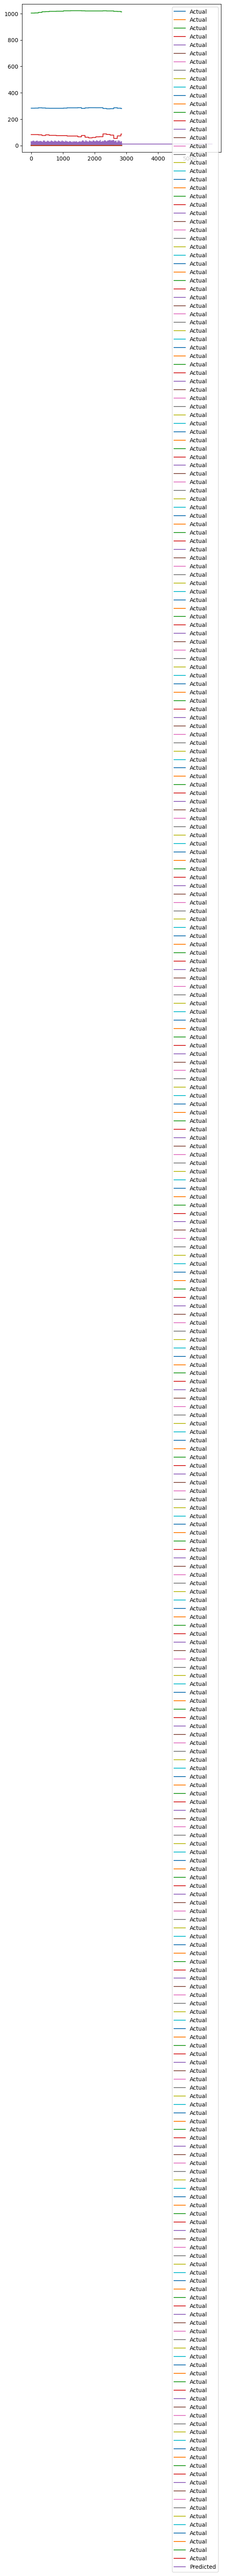

In [20]:
# Call the predict() method on the loaded model object to generate forecasts
output = model.predict(train_data)

# Convert the pandas Series object to a pandas DataFrame
df_output = pd.DataFrame(output, columns=['predicted_mean'])

# Plot the forecasted values against the actual values
plt.plot(train_data.index, train_data.values, label='Actual')
plt.plot(df_output.index, df_output['predicted_mean'], label='Predicted')
plt.legend()
plt.show()

In [21]:
print(test_data.index)

Int64Index([2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857,
            ...
            5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690],
           dtype='int64', length=2843)


In [23]:
# Define the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler object on your data
scaler.fit(test_data)

# Load the trained model object from the file
with open('model.pkl', 'rb') as handle:
    model = pickle.load(handle)

# Call the predict() method on the loaded model object to generate forecasts
output = model.predict(test_data)  # start=test_data.index[0]?

# Convert the pandas Series object to a pandas DataFrame
df_output = pd.DataFrame(output, columns=['predicted_mean'])

# Inverse transform the predicted values to get them back to their original scale
predicted_values = scaler.inverse_transform(df_output)

# Convert the numpy array to a pandas DataFrame and set the index
df_predicted = pd.DataFrame(
    predicted_values, index=df_output.index, columns=['predicted_mean'])

# Print the forecasted values
print(df_predicted)

ValueError: non-broadcastable output operand with shape (2843,1) doesn't match the broadcast shape (2843,304)